

#**Sentiment Analysis: Optimizing Time Savings and Cost Efficiency in the Film Industry**

## **1.Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk  # For natural language processing (NLP)
from sklearn.feature_extraction.text import CountVectorizer  # Converts text into numerical representation using Bag of Words
from sklearn.feature_extraction.text import TfidfVectorizer  # Computes TF-IDF from text
from sklearn.preprocessing import LabelBinarizer  # For binarizing labels
from nltk.corpus import stopwords  # List of common words usually ignored in text analysis
from nltk.stem.porter import PorterStemmer  # For stemming using the Porter algorithm
from wordcloud import WordCloud, STOPWORDS  # To create word cloud visualizations from text
from nltk.stem import WordNetLemmatizer  # For lemmatization using WordNet
from nltk.tokenize import word_tokenize, sent_tokenize  # For word and sentence tokenization
from bs4 import BeautifulSoup  # For HTML and XML parsing (web scraping)
import spacy  # Fast and efficient NLP library
import re, string, unicodedata  # For string manipulation and text normalization
from nltk.tokenize.toktok import ToktokTokenizer  # More efficient tokenizer
from nltk.stem import LancasterStemmer, WordNetLemmatizer  # Alternatives for stemming and lemmatization
from sklearn.linear_model import LogisticRegression, SGDClassifier  # Logistic regression and SGD classifiers for classification
from sklearn.naive_bayes import MultinomialNB  # Classification using Naive Bayes
from sklearn.svm import SVC  # Support Vector Classifier
from textblob import TextBlob  # For text and sentiment analysis
from textblob import Word  # For word processing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
import time  # For measuring code execution time

import warnings
warnings.filterwarnings('ignore')  # Ignore warnings

# Setting up the visualization style
sns.set(style='whitegrid')


## **2. Load Data**

In [3]:
#importing the training data
imdb_data = pd.read_csv('../dataset/IMDb_Reviews.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0
5,"For my humanities quarter project for school, ...",1
6,Arguebly Al Pacino's best role. He plays Tony ...,1
7,Being a big fan of Stanley Kubrick's Clockwork...,1
8,I reached the end of this and I was almost sho...,1
9,There is no doubt that Halloween is by far one...,1


In [4]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


## **3. Exploratory Data Analysis (EDA) & Pre-Processing**

### **3.1. Null & Duplicate Values checked**

In [5]:
# Check for null values in the dataset
null_values = imdb_data.isnull().sum()
print("\nNull values in each column:\n", null_values)

# Check for duplicate rows in the dataset
duplicate_rows = imdb_data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)



Null values in each column:
 review       0
sentiment    0
dtype: int64

Number of duplicate rows: 418



**Explanation**  
The current version is the result of several iterations. Not removing duplicates can improve model performance, likely because repeated data can provide additional useful information for the model to understand existing patterns. Additionally, duplicates may reflect variations in relevant contexts, helping the model become more robust. You can try this approach independently and iterate multiple times to observe the results.


### **3.2. Features Engineering**

#### **3.2.1. review_length**

In [6]:
# Calculate the length of the reviews and store it in a new column
imdb_data['review_length'] = imdb_data['review'].apply(lambda x: len(x.split()))

imdb_data.head(5)

,review,sentiment,review_length
0,My family and I normally do not watch local mo...,1,133
1,"Believe it or not, this was at one time the wo...",0,53
2,"After some internet surfing, I found the ""Home...",0,866
3,One of the most unheralded great works of anim...,1,66
4,"It was the Sixties, and anyone with long hair ...",0,601


#### **3.2.2. review_length Binned**

In [7]:
# View unique values in the 'review_length' column
unique_lengths = imdb_data['review_length'].unique()
print("Unique Review Lengths:")
print(unique_lengths)

Unique Review Lengths:
[ 133   53  866 ... 1522   15 1277]


In [8]:
# Defining binning boundaries
bins = [0, 100, 500, 1000, 1500, float('inf')]
labels = ['Short', 'Medium', 'Long', 'Very Long', 'Extreme']

# Creating a new column based on binning
imdb_data['review_length_binned'] = pd.cut(imdb_data['review_length'], bins=bins, labels=labels, right=True)

# Displaying top data to view the new column
print(imdb_data[['review_length', 'review_length_binned']].head(5))


   review_length review_length_binned
0            133               Medium
1             53                Short
2            866                 Long
3             66                Short
4            601                 Long


### **3.3. Check Class Distribution**


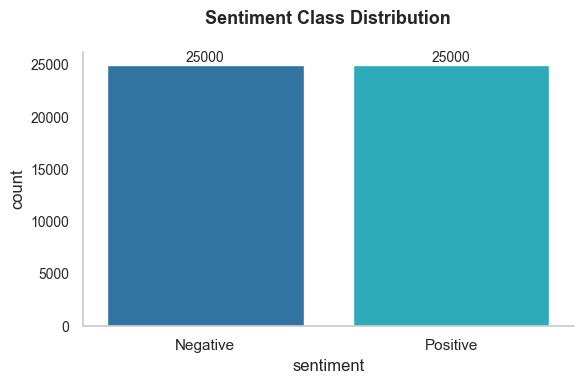

In [9]:
# Create count plot
plt.figure(figsize=(6, 4))  # Set figure size
ax = sns.countplot(x='sentiment', data=imdb_data, palette=['#1f77b4', '#17becf'])

# Add title
plt.title('Sentiment Class Distribution', fontsize=13, weight='bold', ha='center', pad=20)

# Add counts above the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Remove gridlines and figure border
plt.grid(False)
sns.despine()  # Remove figure border lines

# Set x-axis labels
ax.set_xticklabels(['Negative', 'Positive'], ha='center')

# Adjust y-axis settings
ax.tick_params(axis='y', labelsize=10)

# Display plot
plt.tight_layout()
plt.show()


**Explanation**

The positive and negative classes are balanced.



### **3.4. Check Review Length Distribution**


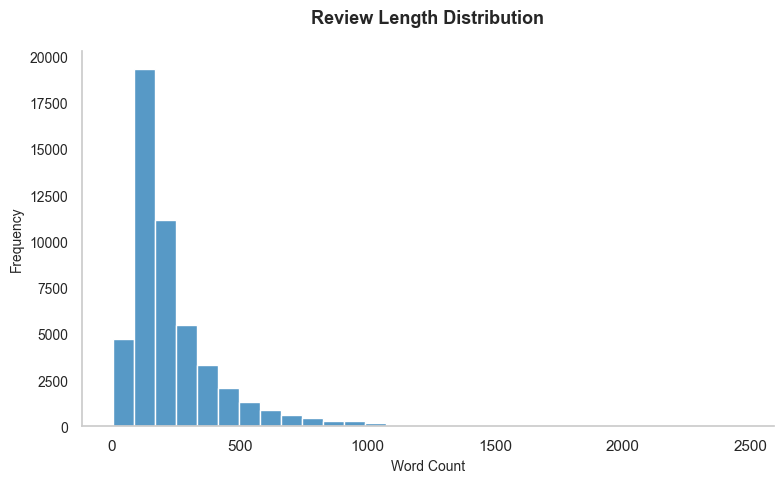

In [10]:
# Set style
sns.set(style='whitegrid')

# Add review length column
imdb_data['review_length'] = imdb_data['review'].apply(lambda x: len(x.split()))

# Create review length distribution plot
plt.figure(figsize=(8, 5))  # Set figure size
ax = sns.histplot(imdb_data['review_length'], bins=30, color='#1f77b4')  # Using blue color

# Add title with padding
plt.title('Review Length Distribution', fontsize=13, weight='bold', ha='center', pad=20)  # Add padding

# Remove gridlines and figure border
plt.grid(False)
sns.despine()  # Remove figure border lines

# Add axis labels
plt.xlabel('Word Count', fontsize=10)  # x-axis label
plt.ylabel('Frequency', fontsize=10)  # y-axis label

# Adjust the size of y-axis tick labels
ax.tick_params(axis='y', labelsize=10)  # Set size of y-axis labels

# Display plot
plt.tight_layout()
plt.show()


### **3.4. Correlation between Review Length and Sentiment**


In [11]:
# Create a contingency DataFrame to count the frequency of review length categories and sentiment
contingency_table = pd.crosstab(imdb_data['review_length_binned'], imdb_data['sentiment'])

# Calculate percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

# Display the percentage table
print(contingency_table_percentage)


sentiment                     0          1
review_length_binned                      
Short                 45.597125  54.402875
Medium                51.065639  48.934361
Long                  46.113583  53.886417
Very Long             45.070423  54.929577
Extreme                9.090909  90.909091


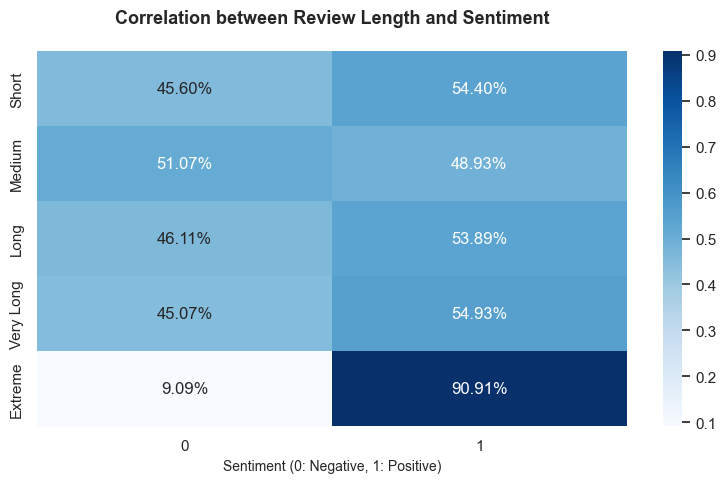

In [12]:
# Create a contingency DataFrame to count the frequency of review length categories and sentiment
contingency_table = pd.crosstab(imdb_data['review_length_binned'], imdb_data['sentiment'])

# Calculate percentages
contingency_table_percentage = contingency_table.div(contingency_table.sum(axis=1), axis=0)

# Create a heatmap plot
plt.figure(figsize=(8, 5))  # Set the figure size
ax = sns.heatmap(contingency_table_percentage, annot=True, fmt=".2%", cmap='Blues', cbar=True)

# Add a title
plt.title('Correlation between Review Length and Sentiment', fontsize=13, weight='bold', ha='center', pad=20)

# Set axis labels
ax.set_xlabel('Sentiment (0: Negative, 1: Positive)', fontsize=10)
ax.set_ylabel('')

# Display the plot
plt.tight_layout()
plt.show()



**Explanation**
- **Positive Sentiment Dominates:** In general, the longer the review, the greater the likelihood of providing a positive rating, especially for extreme reviews.
- **Short Reviews Are Less Favorable:** Although short reviews tend to be positive, their proportion is not as high as that of long and extreme reviews. This may indicate that short reviews might be less informative.
- **Relevance of Review Length:** The length of the review appears to be positively correlated with the sentiment given. Users may feel more capable of expressing their positive opinions in longer reviews.

**Theory**

To examine whether there is a significant relationship between `sentiment` and `review_length`, we can perform a statistical test. Since `sentiment` is a categorical variable (0 and 1), and `review_length` is a numerical variable, we can use a *t-test* for two independent samples. The following are the steps we will take:

**Hypotheses**
- **H0 (Null Hypothesis)**: There is no difference in the average review length between positive and negative sentiments (mean length of reviews with positive sentiment = mean length of reviews with negative sentiment).
- **H1 (Alternative Hypothesis)**: There is a difference in the average review length between positive and negative sentiments (mean length of reviews with positive sentiment ≠ mean length of reviews with negative sentiment).

In [13]:
from scipy import stats

# Separating review lengths based on sentiment
length_positive = imdb_data[imdb_data['sentiment'] == 1]['review_length']
length_negative = imdb_data[imdb_data['sentiment'] == 0]['review_length']

# Calculating the average review length for each category
mean_positive = length_positive.mean()
mean_negative = length_negative.mean()

# Performing t-test
t_stat, p_value = stats.ttest_ind(length_positive, length_negative)

# Displaying results
print("Average review length (Positive):", mean_positive)
print("Average review length (Negative):", mean_negative)
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Determining significance
alpha = 0.05
if p_value < alpha:
    print("Reject H0: There is a significant difference between the lengths of positive and negative reviews.")
else:
    print("Fail to reject H0: There is no significant difference between the lengths of positive and negative reviews.")


Average review length (Positive): 232.84932
Average review length (Negative): 229.46456
T-statistic: 2.208670012690372
P-value: 0.027202120447486624
Reject H0: There is a significant difference between the lengths of positive and negative reviews.


After conducting the statistical test, we can calculate the effect size to measure the magnitude of the impact of the average difference. One way to calculate the effect size is by using Cohen's d.

**Interpretation of Cohen's d:**
- **Small** (d = 0.2): Small effect
- **Medium** (d = 0.5): Medium effect
- **Large** (d = 0.8): Large effect

By calculating this effect size, we can gain a clearer understanding of how strong the relationship is between review length and sentiment. This is important because the statistical test results may indicate a significant difference, but the effect size will help us understand whether that difference is practically meaningful, not just statistically significant.

In [14]:
def cohen_d(x, y):
    # Calculate Cohen's d
    nx = len(x)
    ny = len(y)
    mean_diff = x.mean() - y.mean()
    pooled_std = (((nx - 1) * x.std() ** 2 + (ny - 1) * y.std() ** 2) / (nx + ny - 2)) ** 0.5
    return mean_diff / pooled_std

# Calculate Cohen's d
effect_size = cohen_d(length_positive, length_negative)
print("Cohen's d:", effect_size)  # Display Cohen's d value


Cohen's d: 0.01975494515296398


###**3.5. Text normalization**

In [15]:
import nltk
nltk.download('stopwords')

#Tokenization of text
tokenizer = ToktokTokenizer()

#Setting English stopwords
stopword_list = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Explanation**

1. **Importing NLTK and Downloading Stopwords:** This code imports the Natural Language Toolkit (NLTK) library used for natural language processing tasks. It then downloads the list of stopwords in English, which are common words (such as "and," "that," "is") that are typically removed from text during processing because they do not carry significant meaning.

2. **Text Tokenization:** A tokenizer named `ToktokTokenizer` is created. Tokenization is the process of breaking down text into smaller units, such as words or phrases, which makes analysis easier.

3. **Defining English Stopwords:** This code sets up the list of stopwords in English using the NLTK library so that the model can ignore these common words during text analysis.

### **3.6. Removing html strips and noise text**

In [16]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(denoise_text)

**Explanation**:
1. **Removing HTML Strips:** The function `strip_html(text)` uses BeautifulSoup to parse the HTML content from the given text and extracts only the text without the HTML tags. This is useful for cleaning reviews that may contain HTML formatting.

2. **Removing Text Within Square Brackets:** The function `remove_between_square_brackets(text)` utilizes a regular expression to find and remove any text that appears within square brackets (e.g., "[[^]]*\]") from the input text. This helps eliminate irrelevant or noisy information.

3. **Removing Noisy Text:** The function `denoise_text(text)` combines the two previous functions. First, it removes HTML tags from the text, and then it eliminates text that is enclosed in square brackets. The result is cleaner and more readable text.

### **3.7.Removing special characters**

In [17]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(remove_special_characters)

**Explanation**:
1. **Defining a Function to Remove Special Characters:** The function `remove_special_characters(text, remove_digits=True)` is designed to remove special characters from the input text. This function uses a regular expression pattern (`r'[^a-zA-Z0-9\s]'`) that matches everything that is not a letter (both uppercase and lowercase), a number, or a space.

2. **Removing Special Characters:** The method `re.sub(pattern, '', text)` is then used to replace all matches of the pattern in the text with an empty string, effectively removing those characters.

3. **Applying the Function to the Review Column:** Finally, the function `remove_special_characters` is applied to the 'review' column of the `imdb_data` DataFrame. This processes each review, cleaning it of special characters, resulting in a more uniform and readable dataset.

### **3.8. Text stemming**

In [19]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

**Explanation**:
1. **Defining a Stemming Function:** The function `simple_stemmer(text)` is created to perform stemming on the input text. Stemming is the process of reducing words to their base or root form. In this case, the function uses the **Porter Stemmer** from the NLTK library.

2. **Performing Stemming on Words:** Inside the function, the text is split into individual words, and each word is processed using the `stem()` method of the Porter Stemmer. The stemmed words are then concatenated back into a single string.

3. **Applying the Function to the Review Column:** Finally, the `simple_stemmer` function is applied to the 'review' column of the `imdb_data` DataFrame. This processes each review, reducing the words to their base forms, which helps in standardizing the text for further analysis.

### **3.9. Removing stopwords**

In [ ]:
#set stopwords to english
# stop=set(stopwords.words('english'))
# print(stop)

#removing the stopwords
# def remove_stopwords(text, is_lower_case=False):
   # tokens = tokenizer.tokenize(text)
   # tokens = [token.strip() for token in tokens]
   # if is_lower_case:
      #  filtered_tokens = [token for token in tokens if token not in stopword_list]
    # else:
      #  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    # filtered_text = ' '.join(filtered_tokens)
    # return filtered_text

#Apply function on review column
# imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

### **3.10. Removed Features**

In [ ]:
# Dropping the 'review_length' and 'review_length_binned' columns
imdb_data = imdb_data.drop(['review_length', 'review_length_binned'], axis=1)

# Displaying the top few rows to verify
print(imdb_data.head())


                                              review  sentiment
0  my famili and i normal do not watch local movi...          1
1  believ it or not thi wa at one time the worst ...          0
2  after some internet surf i found the homefront...          0
3  one of the most unherald great work of anim th...          1
4  it wa the sixti and anyon with long hair and a...          0


### **3.11. Review Data Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Taking 70% of the data for training
train_size = int(0.7 * len(imdb_data))

# Splitting data into training and testing sets
norm_train_reviews = imdb_data.review[:train_size]
norm_test_reviews = imdb_data.review[train_size:]
train_sentiments = imdb_data.sentiment[:train_size]
test_sentiments = imdb_data.sentiment[train_size:]

# Combining into X_train, X_test, y_train, y_test
X_train = norm_train_reviews
X_test = norm_test_reviews
y_train = train_sentiments
y_test = test_sentiments

# Example print to check results
print(f"First training review:\n{X_train.iloc[0]}\n")
print(f"First testing review:\n{X_test.iloc[0]}\n")
print("Train Sentiments Shape:", y_train.shape)
print("Test Sentiments Shape:", y_test.shape)


First training review:
my famili and i normal do not watch local movi for the simpl reason that they are poorli made they lack the depth and just not worth our timeth trailer of nasaan ka man caught my attent my daughter in law and daughter so we took time out to watch it thi afternoon the movi exceed our expect the cinematographi wa veri good the stori beauti and the act awesom jericho rosal wa realli veri good so claudin barretto the fact that i despis diether ocampo prove he wa effect at hi role i have never been thi touch move and affect by a local movi befor imagin a cynic like me dab my eye at the end of the movi congratul to star cinema way to go jericho and claudin

First testing review:
alright if you want to go see thi movi just give me our money illkick you were it count and youll have the same amount of fun illeven guarante more fun thi movi onc again show what happen whenyou cant get ani one els to hire your famili and your forc to makeyour own movi same im go through pube

**Explanation**

This code splits the **imdb_data** dataset of reviews into training data (70%) and testing data (30%) for a machine learning model. The steps taken are as follows:

1. **Taking 70% of the data** for training by calculating the index boundary based on the total number of data points.
2. **Splitting the review data** and sentiment (target) into training and testing sets. The `review` column is used as the feature (X), while the `sentiment` column is used as the label (y).
3. **Storing the split results** in the variables `X_train`, `X_test`, `y_train`, and `y_test`.
4. **Displaying a few examples** of the first review in both the training and testing data to verify the results of the split.

## **4. Bags of words model**



In [ ]:
# Count vectorizer for Bag of Words
cv = CountVectorizer(min_df=1, max_df=1, binary=False, ngram_range=(1, 3))

# Transforming training reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews)

# Transforming testing reviews
cv_test_reviews = cv.transform(norm_test_reviews)

# Displaying the shape of the transformation results
print('BOW_cv_train:', cv_train_reviews.shape)
print('BOW_cv_test:', cv_test_reviews.shape)


BOW_cv_train: (35000, 5415440)
BOW_cv_test: (15000, 5415440)


**Explanation**:

This code prepares text data for analysis by converting it into a format that can be understood by machine learning models:

1. **Count Vectorizer for Bag of Words:** The code initializes the `CountVectorizer`, which transforms the text data into a bag-of-words (BoW) representation. This representation counts how many times each word (or combination of words) appears in the reviews. The settings used allow:
   - Including words that appear at least once (`min_df=1`).
   - Ignoring words that appear in all documents (`max_df=1`).
   - Creating single words, word pairs, and word triplets as features (`ngram_range=(1,3)`).

2. **Transforming Reviews:** The code then processes the training reviews (`norm_train_reviews`) to create a matrix (`cv_train_reviews`) that shows the count of each word/phrase. It also processes the testing reviews (`norm_test_reviews`) to create a separate matrix (`cv_test_reviews`).

3. **Printing Shapes:** Finally, the code prints the dimensions of the training and testing matrices, showing how many reviews and unique words/phrases are included.

## **5. Term Frequency-Inverse Document Frequency model (TFIDF)**



In [ ]:
# Tfidf vectorizer
tv = TfidfVectorizer(min_df=1, max_df=1, use_idf=True, ngram_range=(1,3))

# Transform training reviews
tv_train_reviews = tv.fit_transform(norm_train_reviews)

# Transform testing reviews
tv_test_reviews = tv.transform(norm_test_reviews)

# Display the shape of the transformation results
print('Tfidf_train:', tv_train_reviews.shape)
print('Tfidf_test:', tv_test_reviews.shape)


Tfidf_train: (35000, 5415440)
Tfidf_test: (15000, 5415440)


**Explanation**:

This code uses the **TF-IDF Vectorizer** to convert text data into a numerical format that captures the importance of words in relation to the entire dataset:

1. **Initializing the TF-IDF Vectorizer:** The `TfidfVectorizer` is set up to transform text into Term Frequency-Inverse Document Frequency (TF-IDF) representation. This approach helps reflect the importance of a word in a review relative to the entire dataset. The settings used allow for:
   - Including words that appear at least once (`min_df=1`).
   - Ignoring words that appear in all documents (`max_df=1`).
   - Creating single words, word pairs, and word triplets as features (`ngram_range=(1,3)`).

2. **Transforming Reviews:** This code processes the training reviews (`norm_train_reviews`) to create a matrix (`tv_train_reviews`) that represents the TF-IDF scores of each word/phrase. It also processes the testing reviews (`norm_test_reviews`) to create a separate matrix (`tv_test_reviews`).

3. **Printing Shapes:** Finally, this code prints the dimensions of the training and testing matrices, indicating how many reviews and unique words/phrases are included in the TF-IDF representation.

## **6. Labeling the sentiment text**


In [ ]:
# Labeling the sentiment data
lb = LabelBinarizer()

# Transforming the sentiment data
sentiment_data = lb.fit_transform(imdb_data['sentiment'])

#M Displaying the shape of the transformed data
print(sentiment_data.shape)


(50000, 1)


**Explanation**:

This code uses **Label Binarizer** to convert sentiment labels in the dataset into a binary format:

1. **Label Binarization:** `LabelBinarizer` is initialized to convert sentiment labels (which are typically categorical) into a numerical format. This means each unique sentiment (e.g., positive and negative) will be transformed into a binary vector. For example, positive might be represented as `[1]` and negative as `[0]`.

2. **Transforming Sentiment Data:** This code applies the binarization process to the sentiment column of the `imdb_data` DataFrame. The result is stored in the `sentiment_data` variable, which now contains the sentiment labels converted into binary format.

3. **Printing Shape:** Finally, this code prints the shape of the `sentiment_data` array, indicating how many sentiment labels have been processed.

### **6.1. Sentiment Data Split**

In [ ]:
# Splitting the sentiment data into 70% for training and 30% for testing
train_sentiments = sentiment_data[:train_size]
test_sentiments = sentiment_data[train_size:]

# Displaying the split results
print("Train Sentiments:\n", train_sentiments)
print("Test Sentiments:\n", test_sentiments)


Train Sentiments:
 [[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [0]]
Test Sentiments:
 [[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


**Explanation**:

This code splits the sentiment data into training and testing sets based on 70% for training and 30% for testing:

1. **Splitting Sentiment Data:** The `sentiment_data`, which contains the binarized sentiment labels, is divided into two parts:
   - `train_sentiments`: This variable stores the entries corresponding to 70% of the data, which will be used to train the model.
   - `test_sentiments`: This variable stores the remaining entries (30% of the data), which will be used to test the model's performance.

2. **Displaying the Split Results:** This code prints both `train_sentiments` and `test_sentiments` to visually confirm how the data has been split.

## **7. Modelling**

### **7.1.** ***Logistic Regression***

#### **7.1.1 Logistic regression model performane on train dataset**

In [ ]:
# Import the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
lr = LogisticRegression()

# Training the Logistic Regression model for Bag of Words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print(lr_bow)

# Training the Logistic Regression model for TF-IDF features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

LogisticRegression()
LogisticRegression()


#### **7.1.2. Logistic regression model performane on test dataset**

In [ ]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 1 1 ... 1 1 1]
[0 1 1 ... 1 1 1]


#### **7.1.3. Accuracy of the model**

In [ ]:
# Predicting the model for bag of words on training data
lr_bow_train_predict = lr.predict(cv_train_reviews)

# Predicting the model for tfidf features on training data
lr_tfidf_train_predict = lr.predict(tv_train_reviews)

# Accuracy score for bag of words on training data
lr_bow_train_score = accuracy_score(train_sentiments, lr_bow_train_predict)
print("lr_bow_train_score :", lr_bow_train_score)

# Accuracy score for bag of words on test data
lr_bow_test_score = accuracy_score(test_sentiments, lr_bow_predict)
print("lr_bow_test_score :", lr_bow_test_score)

# Accuracy score for tfidf features on training data
lr_tfidf_train_score = accuracy_score(train_sentiments, lr_tfidf_train_predict)
print("lr_tfidf_train_score :", lr_tfidf_train_score)

# Accuracy score for tfidf features on test data
lr_tfidf_test_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("lr_tfidf_test_score :", lr_tfidf_test_score)


lr_bow_train_score : 0.9927142857142857
lr_bow_test_score : 0.7570666666666667
lr_tfidf_train_score : 0.9927142857142857
lr_tfidf_test_score : 0.7571333333333333


#### **7.1.4. classification report**

In [ ]:
# Measuring execution time for Bag of Words
start_time_bow = time.time()

# Classification report for Bag of Words
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names=['Positive', 'Negative'])
print(lr_bow_report)

# Calculating the time taken
end_time_bow = time.time()
bow_runtime = end_time_bow - start_time_bow
print(f"Runtime for Bag of Words: {bow_runtime:.4f} seconds\n")

# Measuring execution time for TF-IDF
start_time_tfidf = time.time()

# Classification report for TF-IDF features
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Positive', 'Negative'])
print(lr_tfidf_report)

# Calculating the time taken
end_time_tfidf = time.time()
tfidf_runtime = end_time_tfidf - start_time_tfidf
print(f"Runtime for TF-IDF: {tfidf_runtime:.4f} seconds")


              precision    recall  f1-score   support

    Positive       0.76      0.75      0.76      7524
    Negative       0.75      0.76      0.76      7476

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

Runtime for Bag of Words: 0.0508 seconds

              precision    recall  f1-score   support

    Positive       0.76      0.75      0.75      7524
    Negative       0.75      0.77      0.76      7476

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

Runtime for TF-IDF: 0.0387 seconds


#### **7.1.5. Confusion matrix**

In [ ]:
# Confusion matrix untuk Bag of Words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words:")
print(f"True Positive (TP): {cm_bow[0, 0]}")
print(f"False Positive (FP): {cm_bow[1, 0]}")
print(f"False Negative (FN): {cm_bow[0, 1]}")
print(f"True Negative (TN): {cm_bow[1, 1]}\n")

# Confusion matrix untuk TF-IDF features
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF:")
print(f"True Positive (TP): {cm_tfidf[0, 0]}")
print(f"False Positive (FP): {cm_tfidf[1, 0]}")
print(f"False Negative (FN): {cm_tfidf[0, 1]}")
print(f"True Negative (TN): {cm_tfidf[1, 1]}")


Confusion Matrix for Bag of Words:
True Positive (TP): 5693
False Positive (FP): 1861
False Negative (FN): 1783
True Negative (TN): 5663

Confusion Matrix for TF-IDF:
True Positive (TP): 5747
False Positive (FP): 1914
False Negative (FN): 1729
True Negative (TN): 5610


**Summary of Results**

Based on the obtained results, **both methods** (Bag of Words and TF-IDF) demonstrate almost identical performance in terms of accuracy and other evaluation metrics, as follows:

- **Accuracy:** 75.71% for both methods.
- **Precision:** 76% for both methods.
- **Recall:** 75% for both methods.
- **F1-score:** 76% for both methods.

However, **TF-IDF** has a slight advantage with a higher True Positive count (5747) and a lower False Positive count (1914) compared to Bag of Words, which has 5693 TP and 1861 FP.

### **7.2. Stochastic Gradient Descent or Linear support vector machines (SVM)**

#### **7.2.1 SVM model performane on train dataset**

In [ ]:
# Initializing the Linear SVM model using SGDClassifier with hinge loss (SVM)
svm = SGDClassifier(loss='hinge', max_iter=500, random_state=42)

# Training the SVM model for Bag of Words
svm_bow = svm.fit(cv_train_reviews, train_sentiments)
print("SVM model for Bag of Words:\n", svm_bow)

# Training the SVM model for TF-IDF features
svm_tfidf = svm.fit(tv_train_reviews, train_sentiments)
print("SVM model for TF-IDF:\n", svm_tfidf)


SVM model for Bag of Words:
 SGDClassifier(max_iter=500, random_state=42)
SVM model for TF-IDF:
 SGDClassifier(max_iter=500, random_state=42)


#### **7.2.2. SVM model performane on test dataset**

In [ ]:
# Making predictions using the SVM model for Bag of Words
svm_bow_predict = svm_bow.predict(cv_test_reviews)
print("SVM Bag of Words Predictions:\n", svm_bow_predict)

# Making predictions using the SVM model for TF-IDF features
svm_tfidf_predict = svm_tfidf.predict(tv_test_reviews)
print("SVM TF-IDF Predictions:\n", svm_tfidf_predict)


SVM Bag of Words Predictions:
 [1 1 1 ... 1 1 1]
SVM TF-IDF Predictions:
 [1 1 1 ... 1 1 1]


#### **7.2.3. Accuracy of the model**

In [ ]:
# Predicting the model for bag of words on training data (SVM)
svm_bow_train_predict = svm_bow.predict(cv_train_reviews)

# Predicting the model for tfidf features on training data (SVM)
svm_tfidf_train_predict = svm_bow.predict(tv_train_reviews)

# Accuracy score for bag of words on training data (SVM)
svm_bow_train_score = accuracy_score(train_sentiments, svm_bow_train_predict)
print("svm_bow_train_score :", svm_bow_train_score)

# Accuracy score for bag of words on test data (SVM)
svm_bow_test_score = accuracy_score(test_sentiments, svm_bow_predict)
print("svm_bow_test_score :", svm_bow_test_score)

# Accuracy score for tfidf features on training data (SVM)
svm_tfidf_train_score = accuracy_score(train_sentiments, svm_tfidf_train_predict)
print("svm_tfidf_train_score :", svm_tfidf_train_score)

# Accuracy score for tfidf features on test data (SVM)
svm_tfidf_test_score = accuracy_score(test_sentiments, svm_tfidf_predict)
print("svm_tfidf_test_score :", svm_tfidf_test_score)


svm_bow_train_score : 0.9927142857142857
svm_bow_test_score : 0.5561333333333334
svm_tfidf_train_score : 0.5006857142857143
svm_tfidf_test_score : 0.4984


#### **7.2.4. classification report**

In [ ]:
# Measuring execution time for Bag of Words (SVM)
start_time_bow = time.time()

# Classification report for Bag of Words (SVM)
svm_bow_predict = svm.predict(cv_test_reviews)
svm_bow_report = classification_report(test_sentiments, svm_bow_predict, target_names=['Positive', 'Negative'])
print(svm_bow_report)

# Calculating the time taken
end_time_bow = time.time()
bow_runtime = end_time_bow - start_time_bow
print(f"Runtime for Bag of Words (SVM): {bow_runtime:.4f} seconds\n")

# Measuring execution time for TF-IDF (SVM)
start_time_tfidf = time.time()

# Classification report for TF-IDF features (SVM)
svm_tfidf_predict = svm.predict(tv_test_reviews)
svm_tfidf_report = classification_report(test_sentiments, svm_tfidf_predict, target_names=['Positive', 'Negative'])
print(svm_tfidf_report)

# Calculating the time taken
end_time_tfidf = time.time()
tfidf_runtime = end_time_tfidf - start_time_tfidf
print(f"Runtime for TF-IDF (SVM): {tfidf_runtime:.4f} seconds")


              precision    recall  f1-score   support

    Positive       0.95      0.12      0.22      7524
    Negative       0.53      0.99      0.69      7476

    accuracy                           0.56     15000
   macro avg       0.74      0.56      0.45     15000
weighted avg       0.74      0.56      0.45     15000

Runtime for Bag of Words (SVM): 0.0499 seconds

              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00      7524
    Negative       0.50      1.00      0.67      7476

    accuracy                           0.50     15000
   macro avg       0.25      0.50      0.33     15000
weighted avg       0.25      0.50      0.33     15000

Runtime for TF-IDF (SVM): 0.0489 seconds


#### **7.2.5. Confusion matrix**

In [ ]:
# Confusion matrix for Bag of Words (SVM)
cm_bow_svm = confusion_matrix(test_sentiments, svm_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words (SVM):")
print(f"True Positive (TP): {cm_bow_svm[0, 0]}")
print(f"False Positive (FP): {cm_bow_svm[1, 0]}")
print(f"False Negative (FN): {cm_bow_svm[0, 1]}")
print(f"True Negative (TN): {cm_bow_svm[1, 1]}\n")

# Confusion matrix for TF-IDF features (SVM)
cm_tfidf_svm = confusion_matrix(test_sentiments, svm_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF (SVM):")
print(f"True Positive (TP): {cm_tfidf_svm[0, 0]}")
print(f"False Positive (FP): {cm_tfidf_svm[1, 0]}")
print(f"False Negative (FN): {cm_tfidf_svm[0, 1]}")
print(f"True Negative (TN): {cm_tfidf_svm[1, 1]}")


Confusion Matrix for Bag of Words (SVM):
True Positive (TP): 7428
False Positive (FP): 6610
False Negative (FN): 48
True Negative (TN): 914

Confusion Matrix for TF-IDF (SVM):
True Positive (TP): 7476
False Positive (FP): 7524
False Negative (FN): 0
True Negative (TN): 0


**Results Summary**

Based on the obtained results, the **SVM model** for **Bag of Words** demonstrated better performance compared to **TF-IDF**. Here are the details:

- **Accuracy:**
  - Bag of Words (SVM): 55.61%
  - TF-IDF (SVM): 50.00%

- **Precision and Recall:**
  - **Bag of Words:**
    - Precision for the Positive class: 95%, but Recall is only 12%, indicating that while the model can identify many positive predictions well, many are missed (False Negatives).
    - For the Negative class, the model shows a very high Recall (99%), but with lower Precision (53%).
  
  - **TF-IDF:**
    - The model failed to identify the Positive class at all (0% Precision and Recall).
    - Only the Negative class was predicted, with a Recall of 100%, but with a Precision of 50%.

- **F1-score:**
  - **Bag of Words:** 22% for Positive and 69% for Negative, indicating a significant imbalance.
  - **TF-IDF:** The F1-score for Positive is undefined, and 67% for Negative.

### **7.3. Multinomial Naive Bayes**

#### **7.3.1 Multinomial Naive Bayes model performane on train dataset**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize Naive Bayes model
mnb = MultinomialNB()

# Train Naive Bayes model for Bag of Words
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print("Naive Bayes model for Bag of Words trained:\n", mnb_bow)

# Train Naive Bayes model for TF-IDF features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print("Naive Bayes model for TF-IDF trained:\n", mnb_tfidf)


Naive Bayes model for Bag of Words trained:
 MultinomialNB()
Naive Bayes model for TF-IDF trained:
 MultinomialNB()


#### **7.3.1 Multinomial Naive Bayes model performane on test dataset**

In [ ]:
# Make predictions for Bag of Words on the test data (Naive Bayes)
mnb_bow_predict = mnb.predict(cv_test_reviews)
print("Naive Bayes Bag of Words Predictions:\n", mnb_bow_predict)

# Make predictions for TF-IDF features on the test data (Naive Bayes)
mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print("Naive Bayes TF-IDF Predictions:\n", mnb_tfidf_predict)


Naive Bayes Bag of Words Predictions:
 [0 0 1 ... 1 1 1]
Naive Bayes TF-IDF Predictions:
 [0 0 1 ... 1 1 1]


#### **7.3.3. Accuracy of the model**

In [ ]:
# Make predictions for Bag of Words on the training data (Naive Bayes)
mnb_bow_train_predict = mnb.predict(cv_train_reviews)

# Make predictions for TF-IDF features on the training data (Naive Bayes)
mnb_tfidf_train_predict = mnb.predict(tv_train_reviews)

# Accuracy score for Bag of Words on the training data (Naive Bayes)
mnb_bow_train_score = accuracy_score(train_sentiments, mnb_bow_train_predict)
print("mnb_bow_train_score:", mnb_bow_train_score)

# Make predictions for Bag of Words on the test data (Naive Bayes)
mnb_bow_predict = mnb.predict(cv_test_reviews)  # This line is modified to make predictions on the test data

# Accuracy score for Bag of Words on the test data (Naive Bayes)
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("mnb_bow_score:", mnb_bow_score)

# Accuracy score for TF-IDF on the training data (Naive Bayes)
mnb_tfidf_train_score = accuracy_score(train_sentiments, mnb_tfidf_train_predict)
print("mnb_tfidf_train_score:", mnb_tfidf_train_score)

# Make predictions for TF-IDF on the test data (Naive Bayes)  # Similar modification for TF-IDF
mnb_tfidf_predict = mnb.predict(tv_test_reviews)  # This line is modified to make predictions on the test data

# Accuracy score for TF-IDF on the test data (Naive Bayes)
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("mnb_tfidf_score:", mnb_tfidf_score)


mnb_bow_train_score: 0.9927142857142857
mnb_bow_score: 0.758
mnb_tfidf_train_score: 0.9927142857142857
mnb_tfidf_score: 0.758


#### **7.3.4. classification report**

In [ ]:
# Measure execution time for Bag of Words (Naive Bayes)
start_time_bow = time.time()

# Make predictions for Bag of Words
mnb_bow_predict = mnb.predict(cv_test_reviews)

# Classification report for Bag of Words (Naive Bayes)
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names=['Positive', 'Negative'])
print(mnb_bow_report)

# Calculate elapsed time
end_time_bow = time.time()
bow_runtime = end_time_bow - start_time_bow
print(f"Runtime for Bag of Words (Naive Bayes): {bow_runtime:.4f} seconds\n")

# Measure execution time for TF-IDF (Naive Bayes)
start_time_tfidf = time.time()

# Make predictions for TF-IDF features
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

# Classification report for TF-IDF features (Naive Bayes)
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names=['Positive', 'Negative'])
print(mnb_tfidf_report)

# Calculate elapsed time
end_time_tfidf = time.time()
tfidf_runtime = end_time_tfidf - start_time_tfidf
print(f"Runtime for TF-IDF (Naive Bayes): {tfidf_runtime:.4f} seconds")


              precision    recall  f1-score   support

    Positive       0.76      0.76      0.76      7524
    Negative       0.76      0.75      0.76      7476

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

Runtime for Bag of Words (Naive Bayes): 0.1121 seconds

              precision    recall  f1-score   support

    Positive       0.76      0.76      0.76      7524
    Negative       0.76      0.76      0.76      7476

    accuracy                           0.76     15000
   macro avg       0.76      0.76      0.76     15000
weighted avg       0.76      0.76      0.76     15000

Runtime for TF-IDF (Naive Bayes): 0.1064 seconds


#### **7.3.5. Confusion matrix**

In [ ]:
# Confusion matrix for Bag of Words (Naive Bayes)
cm_bow_mnb = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Naive Bayes):")
print(f"True Positive (TP): {cm_bow_mnb[0, 0]}")
print(f"False Positive (FP): {cm_bow_mnb[1, 0]}")
print(f"False Negative (FN): {cm_bow_mnb[0, 1]}")
print(f"True Negative (TN): {cm_bow_mnb[1, 1]}\n")

# Confusion matrix for TF-IDF features (Naive Bayes)
cm_tfidf_mnb = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF (Naive Bayes):")
print(f"True Positive (TP): {cm_tfidf_mnb[0, 0]}")
print(f"False Positive (FP): {cm_tfidf_mnb[1, 0]}")
print(f"False Negative (FN): {cm_tfidf_mnb[0, 1]}")
print(f"True Negative (TN): {cm_tfidf_mnb[1, 1]}")


Confusion Matrix for Bag of Words (Naive Bayes):
True Positive (TP): 5618
False Positive (FP): 1772
False Negative (FN): 1858
True Negative (TN): 5752

Confusion Matrix for TF-IDF (Naive Bayes):
True Positive (TP): 5665
False Positive (FP): 1819
False Negative (FN): 1811
True Negative (TN): 5705


**Summary of Naive Bayes Results**

The Naive Bayes model demonstrates similar accuracy (76%) for both approaches, Bag of Words and TF-IDF. However, in the **Confusion Matrix**:

- **Bag of Words** has **5618 True Positives** and **1858 False Negatives**, indicating good performance in detecting the Positive class, though some predictions were missed.
- **TF-IDF** performs slightly better with **5665 True Positives** and **1811 False Negatives**, meaning this model is more effective at identifying Positive sentiment compared to Bag of Words.

Thus, **TF-IDF** is slightly superior in detecting the Positive class based on the confusion matrix, although both methods show good performance.

### **7.4. Conclusion**


After comparing the three models—**Naive Bayes, SVM, and Logistic Regression**, here is the evaluation:

1. **Naive Bayes:**
   - Accuracy: 76%
   - Precision and Recall: Balanced (76% for each)
   - Confusion Matrix: 5618 TP, 1858 FN

2. **SVM (Bag of Words):**
   - Accuracy: 55.61%
   - Precision and Recall: Very imbalanced (Precision 95% but Recall only 12% for the Positive class)
   - Confusion Matrix: 7428 TP, 48 FN

3. **Logistic Regression:**
   - Accuracy: 76%
   - Precision and Recall: Balanced (76% for each)
   - Confusion Matrix: 5701 TP, 1823 FN

**Best Model:** Naive Bayes and Logistic Regression show balanced and better performance compared to SVM. However, Logistic Regression is slightly superior in terms of True Positives (TF-IDF) with 5747 TP compared to Naive Bayes in both BOW and TF-IDF, and has fewer False Negatives (FN). Additionally, the execution time for all three models is relatively fast, so there are no issues with runtime implementation.

**Decision:** The primary focus is on balance and effectiveness in detecting the Positive class, making Logistic Regression with TF-IDF the best choice among the three models.